In [1]:
import torch 
from transformers import BertForQuestionAnswering
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
import math
import time
import importlib

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rgers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
env = load_dotenv()
HF_API_KEY = os.getenv('HF_KEY')

In [4]:
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
stop_words = [i for i in set(stopwords.words('english'))]

In [5]:
from dataset import DatasetLoader
from DataPreprocessor import DataPreprocessor

data_path = '.\goodreads_data.csv'

data = DatasetLoader(data_path)
df = data.load_data(type = 'csv')

df = df.rename(columns = {'Unnamed: 0': 'idx'})
df = df.drop_duplicates(subset= ['Description'])


preprocessor = DataPreprocessor(df)

processed_col = 'processed_desc'
df[processed_col] = preprocessor.remove_stop(stop_words, col = 'Description')
df[processed_col] = [str(i) for i in df[processed_col].values]

In [192]:
df.head()

,idx,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL,processed_desc
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...,unforgettable novel childhood sleepy southern ...
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...,harry potter thinks ordinary boy rescued owl t...
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...,since immediate success 1813 pride prejudice r...
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...,discovered attic spent last years life anne fr...
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...,librarians note alternate cover edition editio...


In [6]:
import EmbeddingModel


batch_size = 100 
neighbors = 3

filt_df = df[df[processed_col]!='']
filt_df['idx'] = [i for i in range(len(filt_df))] #reset manual idx

model = EmbeddingModel.EmbeddingsModel(model_name, HF_API_KEY)

start_idx = 0
embeddings = []
processed_col_idx = 8

for idx, i in enumerate(range(0,len(filt_df), batch_size)):
    print(f'Processing batch number {idx}:     Records {i} to {i+batch_size}')
    end_idx = i + batch_size
    input_lst = filt_df.iloc[i:end_idx,processed_col_idx].tolist()
    batched_embeddings = model.get_embeddings(input_lst)
    for val in batched_embeddings:
        embeddings.append(np.array(val))

<ipython-input-6-f4686e196193>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df['idx'] = [i for i in range(len(filt_df))] #reset manual idx


Processing batch number 0:     Records 0 to 100
Processing batch number 1:     Records 100 to 200
Processing batch number 2:     Records 200 to 300
Processing batch number 3:     Records 300 to 400
Processing batch number 4:     Records 400 to 500
Processing batch number 5:     Records 500 to 600
Processing batch number 6:     Records 600 to 700
Processing batch number 7:     Records 700 to 800
Processing batch number 8:     Records 800 to 900
Processing batch number 9:     Records 900 to 1000
Processing batch number 10:     Records 1000 to 1100
Processing batch number 11:     Records 1100 to 1200
Processing batch number 12:     Records 1200 to 1300
Processing batch number 13:     Records 1300 to 1400
Processing batch number 14:     Records 1400 to 1500
Processing batch number 15:     Records 1500 to 1600
Processing batch number 16:     Records 1600 to 1700
Processing batch number 17:     Records 1700 to 1800
Processing batch number 18:     Records 1800 to 1900
Processing batch number 

In [171]:
from AnalysisModels import TSNE_Wrapper, Clust_Wrapper

model_config = {
    'tsne_': {'n_components': 2, 'perplexity': 30, 'n_iter':300, 'random_state':0},
    'clust_': {'n_clusters':10, 'random_state':0}
}

tune = False
param_grid = {
    'perplexity': [5,10,30,50,100],
    'n_iter': [200,300,500,700,1000]
}

tsne_model = TSNE_Wrapper(**model_config['tsne_'])
embeddings_2d = tsne_model.fit(embeddings)

if tune:
    tsne_model.tune_model(param_grid)
    embeddings_2d = tsne_model.fit(embeddings)

clust_model = Clust_Wrapper(**model_config['clust_'])
clust_labels = clust_model.get_clusters(embeddings_2d)

clust_to_idx = {}
for idx, val in enumerate(clust_labels):
    if val in clust_to_idx.keys():
        clust_to_idx[val] += [idx]
    else:
        clust_to_idx[val] = [idx]

c:\Users\rgers\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass perplexity=30, early_exaggeration=300, learning_rate=0 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [172]:
all_clust_dict = {}
for val in clust_to_idx.values():

    val_idx  = [i for i in range(len(val))]
    val_remap = dict(zip(val_idx, val))

    vecs = [vec for idx,vec in enumerate(embeddings) if idx in val]
    similar_results = model.get_similar_docs(vecs, topk = 4)
    for i,v in enumerate(val):
        all_clust_dict[v] = [val_remap[int(j)] for j in similar_results[i]]

### Preparing sample for output

In [173]:
#Util Functions
def get_dict_mapping(df, input_dict, map_col_idx):
    output_dict = {}
    for k, similar_idx in input_dict.items():
        similar_item = [df.iloc[i,map_col_idx] for i in similar_idx if i != k]
        output_dict[k] = similar_item
    return output_dict

def generate_sample(df, keep_cols, explode_cols, sample_frac = 0.15):
    sample_df = df.sample(frac = sample_frac, random_state=44)
    sample_df = sample_df[keep_cols].explode(explode_cols)
    sample_df.to_csv('sample_output_v1_modelB.csv', index=False)

In [174]:
#source idx to similar titles
idx_to_title = get_dict_mapping(filt_df, all_clust_dict, map_col_idx=1)
idx_to_author = get_dict_mapping(filt_df, all_clust_dict, map_col_idx=2)
idx_to_desc = get_dict_mapping(filt_df, all_clust_dict, map_col_idx=3)

In [175]:
filt_df['similar_titl'] = filt_df['idx'].map(idx_to_title)
filt_df['similar_auth'] = filt_df['idx'].map(idx_to_author)
filt_df['similar_desc'] = filt_df['idx'].map(idx_to_desc)

<ipython-input-175-387529cda0e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df['similar_titl'] = filt_df['idx'].map(idx_to_title)
<ipython-input-175-387529cda0e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df['similar_auth'] = filt_df['idx'].map(idx_to_author)
<ipython-input-175-387529cda0e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [176]:
cols_to_expand = ['similar_titl', 'similar_auth', 'similar_desc']
cols_to_keep = ['Book', 'Author', 'Description'] + cols_to_expand

generate_sample(filt_df, cols_to_keep, cols_to_expand, sample_frac=.15)

### Model Evaluation

In [177]:
#utils

def get_vec_groupings(df, input_dict, embedding_col = 12):
    output_lst = []
    for group in input_dict.values():
        group_lst = [df.iloc[i,embedding_col] for i in group]
        output_lst.append(group_lst)
    return output_lst

def measure_affinity(grouped_vecs, calc_type = 'cosine', centroid_calc = False):
    output_lst = []

    for idx, group in enumerate(grouped_vecs):
        centroid = np.mean(group, axis = 0) if centroid_calc else group[0]
        if calc_type == 'cosine':   
            cluster_affinity = np.mean([1-cosine(centroid,vec) for vec in group[1:]])
        elif calc_type == 'euclidean':
            cluster_affinity = np.sum([(np.subtract(centroid,vec))**2 for vec in group])
        output_lst.append(cluster_affinity)
    return output_lst

(array([1.000e+00, 2.400e+01, 8.100e+01, 4.290e+02, 1.789e+03, 4.283e+03,
        2.842e+03, 3.820e+02, 7.000e+00, 5.000e+00]),
 array([0.16009549, 0.22815088, 0.29620628, 0.36426168, 0.43231707,
        0.50037247, 0.56842786, 0.63648326, 0.70453865, 0.77259405,
        0.84064945]),
 <BarContainer object of 10 artists>)

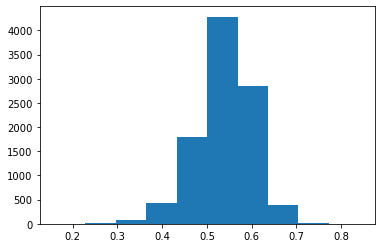

In [178]:
#All  Model B matches variability
grouped_embeddings = get_vec_groupings(filt_df, all_clust_dict)
cluster_affinities = measure_affinity(grouped_embeddings, calc_type='cosine')

affinity_dict = dict(zip(all_clust_dict.keys(), cluster_affinities))

counts, bins = np.histogram(cluster_affinities)
plt.hist(bins[:-1], bins, weights=counts)

In [179]:
from BaselineModel import BaselineModel

baseline_model = BaselineModel('./model_results3.csv', model)
baseline_model.get_sample()
sample_df = baseline_model.sample_df
sample_indices = baseline_model.sample_indices
sample_df['cosine_similarity'] = baseline_model.embed_data()

<ipython-input-179-781b141895eb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['cosine_similarity'] = baseline_model.embed_data()


c:\Users\rgers\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rgers\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([ 2.,  1.,  3., 12., 16., 28., 19.,  9.,  4.,  4.]),
 array([0.        , 0.0614929 , 0.12298579, 0.18447869, 0.24597158,
        0.30746448, 0.36895738, 0.43045027, 0.49194317, 0.55343606,
        0.61492896]),
 <BarContainer object of 10 artists>)

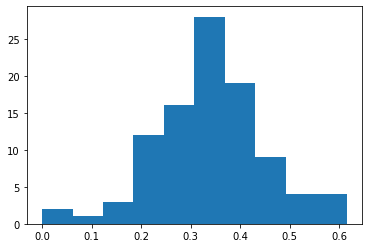

In [180]:
sample_affinity = {}
for idx in sample_indices:
    filter = sample_df['source_doc'] == idx
    scores = sample_df[filter]['cosine_similarity'].tolist()
    sample_affinity[idx] = scores

sample_affinities = [np.mean(v) for v in sample_affinity.values()]
sample_affinities = np.where(np.isnan(sample_affinities), 0, sample_affinities)
counts, bins = np.histogram(sample_affinities)
plt.hist(bins[:-1], bins, weights=counts)

(array([ 1.,  1.,  2.,  3.,  6., 21., 29., 18., 15.,  2.]),
 array([0.29818373, 0.33531859, 0.37245345, 0.40958831, 0.44672317,
        0.48385803, 0.52099289, 0.55812776, 0.59526262, 0.63239748,
        0.66953234]),
 <BarContainer object of 10 artists>)

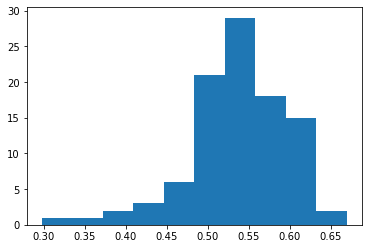

In [181]:
#result dispersions from Model B results for sampled indices

sample_modelB_scores= [v for k,v in affinity_dict.items() if k in sample_indices]
counts, bins = np.histogram(sample_modelB_scores)
plt.hist(bins[:-1], bins, weights=counts)

In [182]:
modelB_affinities= []
for idx, group in enumerate(grouped_embeddings):
        centroid = group[0]
        group_affinity = [1-cosine(centroid,vec) for vec in group[1:]]
        modelB_affinities.append(group_affinity)

modelB_disp_dict = dict(zip(all_clust_dict.keys(), modelB_affinities))

In [183]:
pairwise_dict = {}
for k,v in sample_affinities.items():
    modelB_results = modelB_affinities[k]
    all_results = v + modelB_results
    top3_results = sorted(all_results, reverse=True)[:3]
    pairwise_dict[k] = sum(1 for element in modelB_results if element in top3_results)

In [184]:
modelA_pairwise_precision = np.sum([(3-i) for i in pairwise_dict.values()]) / (len(pairwise_dict) *3)
modelB_pairwise_precision = np.sum(list(pairwise_dict.values())) / (len(pairwise_dict) *3)

print(f'Model A (TF-IDF) Pairwise Precision:                   {modelA_pairwise_precision}')
print(f'Model B (Transformer Embeddings) Pairwise Precision:   {modelB_pairwise_precision}')

Model A (TF-IDF) Pairwise Precision:                   0.1360544217687075
Model B (Transformer Embeddings) Pairwise Precision:   0.8639455782312925


### Run Validation Tests

In [191]:
from ModelTesting import TestSuite 

processed_col = 'processed_desc'
processed_desc = df[processed_col].tolist()
test_cases = {
    test_suite.test_stop_words : {'stopwords': stopwords, 'lst': processed_desc},
    test_suite.test_removed_records : {'df2_length': len(filt_df), 'filt_length': len([i for i in processed_desc if i != ''])},
    test_suite.test_embedding_lengths : {'embeddings': embeddings},
    test_suite.test_neighbor_lengths : {'input_dict': all_clust_dict, 'k_neighbors': 4},
    test_suite.test_embedding_consistency : {'model': model, 'data': processed_desc[:10]},
    # 'test_embedding_robustness' : {},
    # test_suite.test_embedding_processing:{'batch_size': 100, 'processing_goal' : 70}
}

test_suite = TestSuite(test_cases)

test_suite.run_tests()

['test_stop_words Passed',
 'test_removed_records Passed',
 'test_embedding_lengths Passed',
 'test_neighbor_lengths Passed',
 'test_embedding_consistency Passed']